In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stop_words(text):
    stop_words = set(stopwords.words('english'))
    word_tokens = word_tokenize(text)
    filtered_text = ' '.join([word for word in word_tokens if word.lower() not in stop_words])
    return filtered_text
df = pd.read_csv("/content/drive/MyDrive/train.csv")
df = df.sample(frac=1).reset_index(drop=True)
df = df[0:5000]
for x in range(len(df['Recipe'])):
    if type(df['Recipe'][x]) != str:
        df['Recipe'][x] = ''
df2 = pd.read_csv("/content/drive/MyDrive/dev.csv")
for x in range(len(df2['Recipe'])):
    if type(df2['Recipe'][x]) != str:
        df2['Recipe'][x] = ''
# Apply the function to the DataFrame columns
df['Ingredients'] = df['Ingredients'].apply(remove_stop_words)
df['Recipe'] = df['Recipe'].apply(remove_stop_words)
df2['Ingredients'] = df2['Ingredients'].apply(remove_stop_words)
df2['Recipe'] = df2['Recipe'].apply(remove_stop_words)

In [ ]:
file_path = ""
MAX_LENGTH = 150
print("Maximum length of strings in 'Ingredients' column:", MAX_LENGTH)
with open("eng-fra.txt", "w") as file:
    for index, row in df.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

SOS_token = 0
EOS_token = 1
UNK_token = 2

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS", 2: "UNK"}
        self.n_words = 3  # Count SOS, EOS, and UNK

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

input_lang, output_lang, pairs = prepareData('eng', 'fra', True)
print(random.choice(pairs))

def indexesFromSentence(lang, sentence):
    return [lang.word2index.get(word, UNK_token) for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

with open("eng-fra2.txt", "w") as file:
    for index, row in df2.iterrows():
        file.write(f"{row['Recipe']}:::{row['Ingredients']}\n")

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    file_name = file_path + 'eng-fra2.txt'
    lines = open(file_name, encoding='utf-8').\
        read().strip().split('\n')

    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split(':::')] for l in lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

dev_input_lang, dev_output_lang, dev_pairs = prepareData('eng', 'fra', True)
print(random.choice(dev_pairs))

In [ ]:
import torch
import torch.nn as nn

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.lstm(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.lstm = nn.LSTM(self.hidden_size, self.hidden_size)  # Change GRU to LSTM
        self.out = nn.Linear(self.hidden_size * 2, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        _, (hidden, cell_state) = self.lstm(embedded, hidden)  # Change GRU to LSTM

        attn_weights = F.softmax(torch.bmm(hidden, encoder_outputs.T.unsqueeze(0)), dim=-1)
        attn_output = torch.bmm(attn_weights, encoder_outputs.unsqueeze(0))

        concat_output = torch.cat((attn_output[0], hidden[0]), 1)

        output = F.log_softmax(self.out(concat_output), dim=1)

        return output, (hidden, cell_state), attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device), torch.zeros(1, 1, self.hidden_size, device=device)


In [ ]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
teacher_forcing_ratio = 1

def train_attn(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden, encoder_cell = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, (encoder_hidden, encoder_cell) = encoder(
            input_tensor[ei], (encoder_hidden, encoder_cell))
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden
    decoder_cell = encoder_cell  # Initialize decoder's cell state with encoder's last cell state

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Without teacher forcing: use its own predictions as the next input
        for di in range(target_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # detach from history as input

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length


In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np
%matplotlib inline

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def evaluate_attn(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden, encoder_cell = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, (encoder_hidden, encoder_cell) = encoder(input_tensor[ei],
                                                     (encoder_hidden, encoder_cell))
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden
        decoder_cell = encoder_cell  # Initialize decoder's cell state with encoder's last cell state

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, (decoder_hidden, decoder_cell), decoder_attention = decoder(
                decoder_input, (decoder_hidden, decoder_cell), encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]


In [ ]:
def trainIters_attn(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        encoder_hidden, encoder_cell = encoder.initHidden()  # Initialize encoder's hidden and cell states
        decoder_hidden, decoder_cell = encoder_hidden, encoder_cell  # Initialize decoder's hidden and cell states

        loss = train_attn(input_tensor, target_tensor, encoder,
                          decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)


2m 14s (- 8m 57s) (1000 20%) 5.3149
4m 19s (- 6m 29s) (2000 40%) 4.3392
6m 29s (- 4m 19s) (3000 60%) 4.0180
8m 32s (- 2m 8s) (4000 80%) 3.8480
10m 38s (- 0m 0s) (5000 100%) 3.7241


<Figure size 640x480 with 0 Axes>

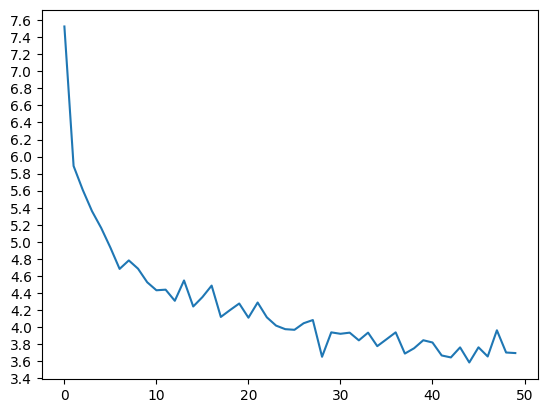

In [ ]:
hidden_size = 256
encoder = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters_attn(encoder, attn_decoder, 5000, print_every=1000)

In [ ]:
def evaluateRandomly_attn(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attention= evaluate_attn(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly_attn(encoder, attn_decoder)

>  tb cumin seeds bay leaves tb coriander seeds cardamon pods cinnamon stick long ts turmeric ts cloves c canola or other mild oil ts black peppercorns
= heat a heavy frying pan over medium heat . toss all the spices together except the turmeric and put them in the hot pan . dry toast the spices stirring constantly for min or until they turn a few shades darker and begin to release their aromas . transfer them to a bowl and let cool completely . add the turmeric and them grind all the spices to a fine powder in a spice mill . stir the spice in with the oil in a clean dry container . cover and let sit at room temperature for three days or until the desired taste is reached . stir or shake once a day . strain through cheesecloth into a clean dry bottle .
< combine all ingredients except the ingredients except the salt . cover the heat and simmer for hour . add the remaining ingredients and simmer for hour . add the remaining ingredients and simmer for hour . add the remaining ingredients